In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.0.0
sys.version_info(major=3, minor=7, micro=6, releaselevel='final', serial=0)
matplotlib 3.1.3
numpy 1.18.1
pandas 1.0.1
sklearn 0.22.1
tensorflow 2.0.0
tensorflow_core.keras 2.2.4-tf


In [2]:
# 1. 预处理
# 2. 搭建模型
# 2.1 encoder
# 2.2 attention
# 2.3 decoder
# 2.4 loss & optimizer
# 2.5 train
# 3. evaluation
# 3.1 给序列，出结果
# 3.2 可视化结果

In [3]:
## 西班牙语预处理, 取消注音
path = "../data_span_en/spa.txt"

import unicodedata
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

en_sentence = "Then what？"
sp_sentence = "¿Entonces qué?"

print(unicode_to_ascii(en_sentence))
print(unicode_to_ascii(sp_sentence))

Then what？
¿Entonces que?


In [4]:
## 处理句子
import re
def preprocess_sentence(s):
    s = unicode_to_ascii(s.lower().strip())
    # 标点符号前后加空格
    s = re.sub(r"([?.!,¿])", r" \1 ", s)
    s = re.sub(r'[" "]+', " ", s)
    # 除了标点和单词全变成空格
    s = re.sub(r'[^a-zA-Z?.!,¿]', " ", s)
    # 去掉前后空格
    s = s.rstrip().strip()
    s = '<start> ' + s + ' <end>'
    return s

print(preprocess_sentence(sp_sentence))
# print(preprocess_sentence(en_sentence))
# print(preprocess_sentence(sp_sentence))

<start> ¿ entonces que ? <end>


In [5]:
def parse_data(filename):
    lines = open(filename, encoding='UTF-8').read().strip().split('\n')
    sentence_pairs = [line.split('\t') for line in lines]
    preprocessed_sentence_pairs = [
        (preprocess_sentence(en), preprocess_sentence(sp)) for en, sp in sentence_pairs]
#     print(preprocessed_sentence_pairs)
    return zip(*preprocessed_sentence_pairs)

en_dataset, sp_dataset = parse_data(path)
print(en_dataset[-1])
print(sp_dataset[-1])

<start> if you want to sound like a native speaker , you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo . <end>
<start> si quieres sonar como un hablante nativo , debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un musico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado . <end>


In [6]:
a = [(1, 2), (3, 4), (5, 6)]
c,d = zip(*a)
print(c,d)

(1, 3, 5) (2, 4, 6)


In [7]:
# sentence embedding --> 将句子转化为tensor

def tokenizer(lang):
    lang_tokenizer = keras.preprocessing.text.Tokenizer(num_words=None, filters='',split=' ')
    lang_tokenizer.fit_on_texts(lang)
    tensor = lang_tokenizer.texts_to_sequences(lang)
    tensor = keras.preprocessing.sequence.pad_sequences(tensor, 
                                                        padding='post')
    return tensor, lang_tokenizer

# shape: [30000, max_sentences_length]
input_tensor, input_tokenizer = tokenizer(sp_dataset[0: 30000])
output_tensor, output_tokenizer = tokenizer(en_dataset[0: 30000])

print(input_tensor.shape)

def max_length(tensor):
    return max(len(t) for t in tensor)

max_length_input  = max_length(input_tensor)
max_length_output  = max_length(output_tensor)
print(max_length_input, max_length_output)

(30000, 16)
16 11


In [8]:
from sklearn.model_selection import train_test_split

# 20%作为测试集
input_train, input_eval, output_train, output_eval = train_test_split(input_tensor, output_tensor, test_size=0.2)
print(input_train[0:100])
print("训练集样本数：", len(input_train))
print("测试集样本数：", len(input_eval))

[[   1   59   18 ...    0    0    0]
 [   1   47  307 ...    0    0    0]
 [   1  207   11 ...    0    0    0]
 ...
 [   1 2329   56 ...    0    0    0]
 [   1 1073   34 ...    0    0    0]
 [   1   94   16 ...    0    0    0]]
训练集样本数： 24000
测试集样本数： 6000


In [9]:
def convert(example, tokenizer):
    for t in example:
        if t != 0:
            print('%d ---> %s' % (t, tokenizer.index_word[t]))
            
convert(input_train[0], input_tokenizer)
print()
convert(output_train[0], output_tokenizer)

1 ---> <start>
59 ---> tomas
18 ---> lo
769 ---> intenta
3 ---> .
2 ---> <end>

1 ---> <start>
5 ---> tom
1934 ---> tries
3 ---> .
2 ---> <end>


In [10]:
def make_dataset(input_tensor, output_tensor,
                 batch_size, epochs, shuffle):
    dataset = tf.data.Dataset.from_tensor_slices((input_tensor, output_tensor))
    if shuffle:
        dataset = dataset.shuffle(30000)
        dataset = dataset.repeat(epochs).batch(batch_size, drop_remainder=True)
    return dataset

batch_size = 64
epochs = 20

train_dataset = make_dataset(input_train, output_train, batch_size, epochs, True)
eval_dataset = make_dataset(input_eval, output_eval, batch_size, 1, False)

In [11]:
for x,y in train_dataset.take(1):
    print(x.shape)
    print(y.shape)

(64, 16)
(64, 11)


In [12]:
embedding_units = 256
# RNN Encoder 的单元数量, 最后输出1024个值
encoding_units = 1024
# RNN Decoder 的单元数量，最后输出1024个值
decoding_units = 1024
input_vocab_size = len(input_tokenizer.word_index) + 1
output_vocab_size = len(output_tokenizer.word_index) + 1

In [13]:
class Encoder(keras.Model):
    def __init__(self, vocab_size, embedding_units, encoding_units, batch_size):
        super(Encoder, self).__init__()
        self.batch_size = batch_size
        self.encoding_units = encoding_units
        self.embedding = keras.layers.Embedding(vocab_size, embedding_units)
        
        self.gru = keras.layers.GRU(self.encoding_units,
                                    return_sequences = True,
                                    return_state = True,
                                    recurrent_initializer = 'glorot_uniform')
    
    def call(self, input_sentence, hidden):
        # before embedding: x.shape = (batch_size, length)
        # after embedding: s.shape = (batch_size, length, embedding_units)
        x = self.embedding(input_sentence)
#         print(x.shape)
        output, state = self.gru(x, initial_state = hidden)
        return output, state
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_size, self.encoding_units))
    
encoder = Encoder(input_vocab_size, embedding_units, encoding_units, batch_size)
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(x, sample_hidden)

print("sample_output shape:", sample_output.shape)
print("sample_hidden shape:", sample_hidden.shape)

sample_output shape: (64, 16, 1024)
sample_hidden shape: (64, 1024)


In [14]:
class BahdanauAttention(keras.Model):
    def __init__(self, attention_units):
        super(BahdanauAttention, self).__init__()
        self.W1 = keras.layers.Dense(attention_units)
        self.W2 = keras.layers.Dense(attention_units)
        self.V = keras.layers.Dense(1)
        
    def call(self, decoder_hidden, encoder_outputs):
        # decoder_hidden shape: (batch_size, encoding_units)
        # encoder_output shape: (batch_size, length, encoding_units)
        decoder_hidden_with_time_axis = tf.expand_dims(decoder_hidden, 1)
        
        # before V: (batch_size, length, attention_units)
#         print( tf.nn.tanh(
#                 self.W1(encoder_outputs) + self.W2(decoder_hidden_with_time_axis)).shape)
        # after V: (batch_size, length, 1)
        score = self.V(
            tf.nn.tanh(
                self.W1(encoder_outputs) + self.W2(decoder_hidden_with_time_axis)))
        
        # shape: (batch_size, length, 1)
        attention_weights = tf.nn.softmax(score, axis = 1)
        
        # shape: (batch_size, length, encoding_units)
        context_vector = attention_weights * encoder_outputs
        
        # shape: (batch_size, encoding_units)
        context_vector = tf.reduce_sum(context_vector, axis=1)
        
        return context_vector, attention_weights

attention_model = BahdanauAttention(10)
attention_results, attention_weights = attention_model(sample_hidden, sample_output)
print("attention_results shape:", attention_results.shape)
print("atteion_weigths shape:", attention_weights.shape)

attention_results shape: (64, 1024)
atteion_weigths shape: (64, 16, 1)


In [15]:
a = tf.ones((4,1,2))
b = tf.ones((4,1,3))
c = tf.concat([a,b],axis = -1)
print(c.shape)
d = tf.reduce_sum(a, axis=1)
print(d)



(4, 1, 5)
tf.Tensor(
[[1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]], shape=(4, 2), dtype=float32)


In [16]:
class Decoder(keras.Model):
    def __init__(self, vocab_size, embedding_units, decoding_units, batch_size):
        super(Decoder, self).__init__()
        self.batch_size = batch_size
        self.decoding_units = decoding_units
        self.embedding = keras.layers.Embedding(vocab_size, embedding_units)
        self.gru = keras.layers.GRU(self.decoding_units,
                                    return_sequences = True,
                                    return_state = True,
                                    recurrent_initializer = 'glorot_uniform')
        self.fc = keras.layers.Dense(vocab_size)
        self.attention = BahdanauAttention(self.decoding_units)
        
    def call(self, input_word, hidden, encoding_outputs):
        # context_vector shape: (batch_size, encoding_units)
        context_vector, attention_weights = self.attention(hidden, encoding_outputs)
        
        x = input_word
        # before embedding: x.shape: (batch_size, 1)
        # after embedding: x.shape(batch_size, 1, embedding_units)
        x = self.embedding(x)
        
        # context_vector shape: (batch_size, 1, encoding_units)
        context_vector = tf.expand_dims(context_vector, 1)
        
        # combined_x shape: (batch_size, 1, encoding_units + embedding_units)
        combined_x = tf.concat([context_vector, x], axis = -1)
        
        # output shape: (batch_size, 1, decoding_units)
        # state shaoe: (batch_size, decoding_units)
        output, state = self.gru(combined_x)
        
        # output shape: (batch_size, decoding_units)
        output = tf.reshape(output, shape = (-1, output.shape[2]))
        
        # output shape: (batch_size, vocab_size)
        output = self.fc(output)
        
        return output, state, attention_weights
    

decoder = Decoder(output_vocab_size, embedding_units, decoding_units, batch_size)
outputs = decoder(tf.random.uniform((batch_size, 1)), sample_hidden, sample_output)

decoder_output, decoder_hidden, decoder_aw = outputs

print("decoder_output shape:", decoder_output.shape)
print("decoder_hidden shape:", decoder_hidden.shape)
print("decoder_attention_weights shape:", decoder_aw.shape)

decoder_output shape: (64, 4935)
decoder_hidden shape: (64, 1024)
decoder_attention_weights shape: (64, 16, 1)


In [17]:
optimizer = keras.optimizers.Adam()

# 这里reduction设置成none是为了将sentence中padding的部分做去除操作，先不聚合
loss_object = keras.losses.SparseCategoricalCrossentropy(from_logits = True, reduction = 'none')

def loss_function(real, pred):
    # 补长padding的部分设置成0，不参与loss的计算
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

In [20]:
# @tf.function
def train_step(inp, targ, encoding_hidden):
    loss = 0
    with tf.GradientTape() as tape:
        encoding_outputs, encoding_hidden = encoder(inp, encoding_hidden)
        
        decoding_hidden = encoding_hidden
        
        # e.g. <start> I am here <end>
        # 1. <start> -> I
        # 2. I -> am
        # 3. am -> here
        # 4. here -> <end>
        
        for t in range(0, targ.shape[1] - 1):
            # decoding_input shape: (batch_size, 1)
            decoding_input = tf.expand_dims(targ[:, t], 1)
            
            predictions, decoder_hidden, _ = decoder(decoding_input, decoding_hidden, encoding_outputs)
            print(predictions.shape)
            print(targ[:, t+1].shape)
            print(targ[:, t+1])
            loss += loss_function(targ[:, t+1], predictions)
    
    batch_loss = loss / int(targ.shape[0])
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    return batch_loss

In [21]:
epochs = 10
steps_per_epoch = len(input_tensor) // batch_size

for epoch in range(epochs):
    start = time.time()
    
    encoding_hidden = encoder.initialize_hidden_state()
    total_loss = 0
    for (batch, (inp, targ)) in enumerate(
        train_dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, encoding_hidden)
        total_loss += batch_loss
        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {: .4f}'.format(epoch + 1, batch, batch_loss.numpy()))
    print('Epoch {} Loss {:.4f}'.format(epoch + 1, total_loss / steps_per_epoch))
    
    print('Time take for 1 epoch {} sec \n'.format(time.time() - start))

(64, 4935)
(64,)
tf.Tensor(
[  20    4    4    4   21   25   10   14   32   14    4  562  120   29
 2015    4   42 4809   27    6   46   56    6   32    4  125   22    6
   21    5    6    4  124    4   20    4   10    4   28 1582    6    4
   86    4    6    4   24   20   28   94    8   71    6    4    6   10
   28   52   10   27   16   27    5    4], shape=(64,), dtype=int32)
(64, 4935)
(64,)
tf.Tensor(
[  11   38  210   47 2963    4   11   11   11  870  100   13  142 1491
   49  133    6    8 1001   25   11   40   23  223   65   20   53   23
  168  401   63 4118   31   95  113   26   11   65   92   13   29   29
 2024   25   23   26   28   11   23   19   10   23   23   25   23  164
  230   11    8   11   23    8    8   65], shape=(64,), dtype=int32)
(64, 4935)
(64,)
tf.Tensor(
[  32   40   43  140 1128   72  204   33   13   67   12 1820   13    3
   90   20   72  517   41 2202   64 1541   67  986 1649   44   33 1698
    8 1072   15   21  104   20    8  488   58  250  106 1416   15   

(64, 4935)
(64,)
tf.Tensor(
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(64,), dtype=int32)
(64, 4935)
(64,)
tf.Tensor(
[  4   6  21   6  52   5  60   4  27   4  75  14   5   4 178   5  14  20
   6   4   4 318  13  10  46   5  52  60  42  19   4 157   4  16   4  58
  60   4  32 189  13  14  14   5   4   5   5  24   5   6   5   4  42   4
  94   4  57  28   4   4  29   4  30   4], shape=(64,), dtype=int32)
(64, 4935)
(64,)
tf.Tensor(
[  18   43  394   92   11  137  621   62  276  135    6  508    8  164
 1950   11   51  552   23  336  114  103  104   11   11 1914   42  180
    6  113   35 1224   30   63  239  400  180   18   42    8 3964   76
   26 1456  699    8  118    6    8   24   75   25    6   26    5   25
   11   43   62   18    6   29   12   38], shape=(64,), dtype=int32)
(64, 4935)
(64,)
tf.Tensor(
[  34   60  145   33   13 1030    5   48  667   31   36   15   48   12
  949 3238    9   

KeyboardInterrupt: 

In [63]:
def evaluate(input_sentence):
    attention_matrix = np.zeros((max_length_output, max_length_input))
    input_sentence = preprocess_sentence(input_sentence)
    inputs = [input_tokenizer.word_index[token] for token in input_sentence.split(' ')]
#     print(inputs)
    inputs = keras.preprocessing.sequence.pad_sequences([inputs], maxlen=max_length_input, padding = 'post')
#     print(inputs)
    inputs = tf.convert_to_tensor(inputs)
    results = ''
    encoding_hidden = tf.zeros(shape=(1, encoding_units))
    encoding_outputs, encoding_hidden = encoder(inputs, encoding_hidden)
    decoder_hidden = encoding_hidden
    
    # decoding_input shape: (1, 1)
    decoding_input = tf.expand_dims([output_tokenizer.word_index['<start>']], 0)
    
    for t in range(max_length_output):
        # attention_weights.shape: (batch_size, input_length, 1) == (1, input_length, 1)
        predictions, decoding_hidden, attention_weights = decoder(decoding_input, decoder_hidden, encoding_outputs)
        
        # attention_weights.shape: (16,)
        attention_weights = tf.reshape(attention_weights, (-1, ))
        
        attention_matrix[t] = attention_weights.numpy()
        
        # predicitons shape: (batch_size, vocab_size) (1, 4935)
        prediction_id = tf.argmax(predictions[0]).numpy()
        results += output_tokenizer.index_word[prediction_id] + ' '
        if(output_tokenizer.index_word[prediction_id] == '<end>'):
            return results, input_sentence, attention_matrix
        
        decoding_input = tf.expand_dims([prediction_id], 0)
    return results, input_sentence, attention_matrix

In [64]:
def plot_attention(attention_matrix, input_sentence, predicted_sentence):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention_matrix, cmap='viridis')
    
    font_dict = {'fontsize': 14}
    ax.set_xticklabels(['']+input_sentence, fontdict = font_dict, rotation = 90)
    ax.set_yticklabels(['']+predicted_sentence, fontdict = font_dict)
    plt.show()

In [65]:
def translate(input_sentence):
    results, input_sentece, attention_matrix = evaluate(input_sentence)
    print("Input: %s" % (input_sentece))
    print("Prediceted translation: %s" % (results))
    
    attention_matrix = attention_matrix[:len(results.split(' ')),
                                        :len(input_sentece.split(' '))]
    
    plot_attention(attention_matrix, input_sentece.split(' '), results.split(' '))

Input: <start> ¿ entonces que ? <end>
Prediceted translation: what ? <end> 


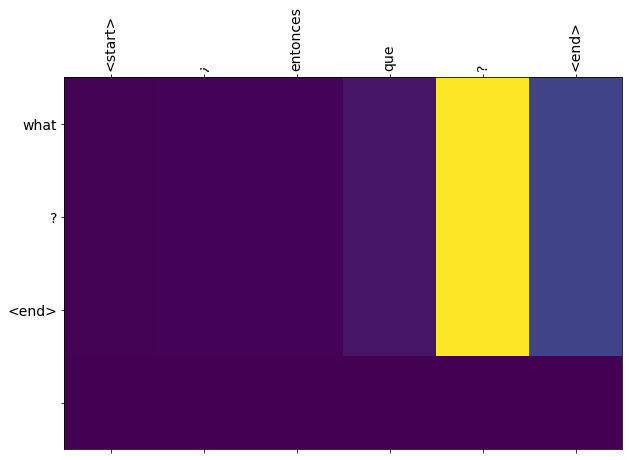

In [66]:
# en_sentence = "Then what？"
sp_sentence = "¿Entonces qué?"
translate(sp_sentence)